# Building MCMC from scratch



### Monte Carlo

"[Monte Carlo methods, or Monte Carlo experiments](https://en.wikipedia.org/wiki/Monte_Carlo_method), are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle."


Simple example: calculate $\pi$ with Monte Carlo methods

In [ ]:
import numpy as np
# generate uniformly random points within a square of radius 2R with R=1

N = 5000 #points

points = np.random.uniform(-1,1, (N,2))


In [ ]:
inside = (np.sqrt(points[:, 0]**2+ points[:, 1]**2)<1)

res = inside.sum()

ratio = res / N

approx_pi = 4*ratio

print(approx_pi)

3.1632


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
figure = plt.figure(figsize=(12,12))

<Figure size 1200x1200 with 0 Axes>

(-1.25, 1.25)

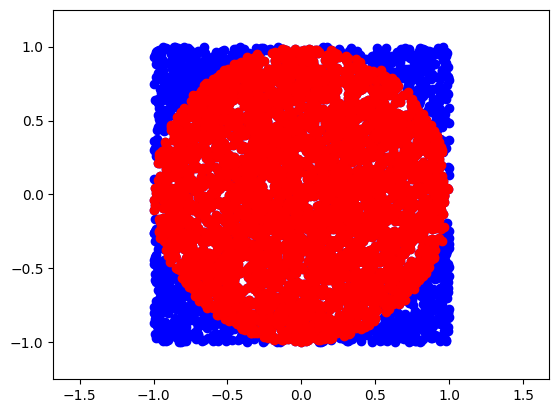

In [ ]:
plt.plot(points[:,0],points[:,1],'o', color='blue')
plt.plot(points[inside][:,0],points[inside][:,1],'o', color='red')

plt.axis('equal')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)



---



## Metropolis-Hastings

"A [Markov chain or Markov process](https://en.wikipedia.org/wiki/Markov_chain) is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. Informally, this may be thought of as, *'What happens next depends only on the state of affairs now'*."

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/260px-Markovkate_01.svg.png" alt="alternatetext">


*The defining characteristic of a Markov chain is that no matter how the process arrived at its present state, the possible future states are fixed. In other words, the probability of transitioning to any particular state is dependent solely on the current state and hence they are referred to a ["Memoryless"](https://wiki.ubc.ca/Course:CPSC522/Markov_Chains). Markov Chains can be modeled as a finite state machine that shows how a system transitions from one state to another and with what probability.*

The condition of **detailed balance** of a Markov chain says that we should move in a reversible way, meaning the probability of moving from state $i$ to state $j$ is the same of moving from state $j$ to state $i$, or $\pi_{i}P_{ij}=\pi_{j}P_{ji}$. This condition is used as a guide to design our MCMC, see later.


"[Markov chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain."

MCMC algorithms are all constructed to have a stationary distribution. However, we require extra conditions to ensure that they converge to such distribution. Please see concept of [ergodicity](https://projecteuclid.org/journals/annals-of-applied-probability/volume-16/issue-3/On-the-ergodicity-properties-of-some-adaptive-MCMC-algorithms/10.1214/105051606000000286.full), starting from a simpler definition [here](https://en.wikipedia.org/wiki/Ergodicity).



### The Algorithm:



1)   Choose an initial value for the parameter $x_i$

2)   Choose a new $x_{i+1}$ by sampling from an easy-to-sample PROPOSAL (aka TRIAL) DISTRIBUTION (dubbed $q$) that allow to do the transition from $q(x_{i+1}|x_{i})$. This is a sort of perturbation from the state $x_{i}$ to $x_{i+1}$

3) Accept the new proposed state? The Metropolis-Hastings criterion is:


$p(x_{i+1}|x_{i}) = min\{1,\frac{p(x_{i+1})q(x_{i}|x_{i+1})}{p(x_{i})q(x_{i+1}|x_{i})}\}$

4) If the probability of point 3 is larger than the value taken from a uniform distribution between [0,1], then accept the new state; otherwise, remain in the old state

5) Iterate from step 2 until we have "enough" samples.

    --- we will see later convergence criteria ---

Notice that if $q(x_{i}|x_{i+1})=q(x_{i+1}|x_{i})$ (detailed balance) we get the Metropolis criterion (drop the Hastings part), and get:

$p(x_{i+1}|x_{i}) = min\{1,\frac{p(x_{i+1})}{p(x_{i})}\}$

      take a minute to make sense of this formula



In [ ]:
def metropolis(func, draws=10000):

  trace = np.zeros(draws)
  old_x = 0.5 #starting point
  old_prob = func.pdf(old_x)

  delta = np.random.normal(0,0.5,draws) #trial distribution

  for i in range(draws):
    new_x = old_x + delta[i]
    new_prob = func.pdf(new_x)
    acceptance = new_prob/old_prob

    if(acceptance>np.random.uniform(0,1)):
      trace[i] = new_x
      old_x = new_x
      old_prob = new_prob
    else:
      trace[i] = old_x # remain in the same state

  return trace

Now another (very) simple problem. MCMC of a beta function (yes, we already know its pdf... if you are thinking 'what's the point?', we are just introducing the mechanism of the MCMC sampling with a concrete simple implementation).



<ipython-input-37-d9c755d2d8e9>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C1" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.
  plt.plot(x,y,'C1',lw=3,label='True Distribution',color='red')


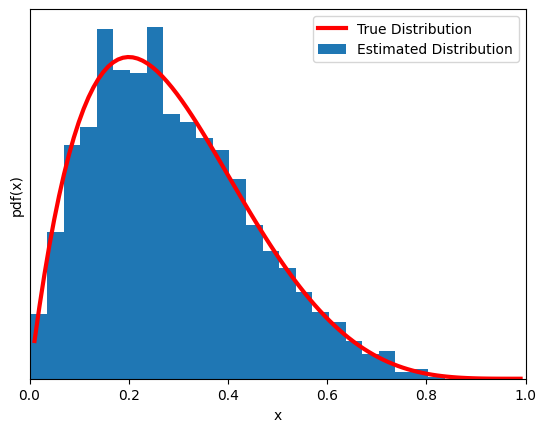

In [ ]:
import scipy.stats as stats

np.random.seed(123)
#--- results from mcmc
func = stats.beta(2,5)
trace = metropolis(func=func)
#--- for plotting the true pdf for comparison
x = np.linspace(0.01,0.99,100)
y = func.pdf(x)
#---
plt.xlim(0,1)
plt.plot(x,y,'C1',lw=3,label='True Distribution',color='red')
plt.hist(trace[trace>0],bins=25, density=True, label='Estimated Distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend()


What is Bayesian in all this?
Make connection to what we have done so far for inferential problems using PyMC. (Notes in class)

After remembering this connection (real-world problems, not like the above), hopefully you are now fully appreciating the power of MCMC...  



---





## Metropolis-Hastings vs Hamiltonian Monte Carlo / NUTS: A simplified introduction


NUTS paper http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf

Hamiltonian Monte Carlo (HMC) enhances the Metropolis Hastings (MH) algorithm by incorporating a more complex proposal distribution informed by Hamiltonian mechanics. Unlike MH, which relies on random walks and becomes inefficient in high-dimensional spaces, HMC facilitates more efficient exploration through dynamically sized jumps based on the local (negative log) likelihood landscape.

### Hamiltonian Mechanics in HMC
HMC uses differential equations from Hamiltonian mechanics to relate position (`Q`) and momentum (`P`), allowing for adaptive jumps in the parameter space. These jumps are guided by:
- **Potential Energy (`V`)**, derived from the negative log-likelihood, indicating the model's fit.
- **Kinetic Energy (`K`)**, associated with the momentum variables, reflecting movement through the parameter space.

The core of HMC lies in its use of Hamilton's equations to simulate the dynamics of a system:
- **Position Update**: $( \frac{dQ}{dT} = P ) $
- **Momentum Update**: $( \frac{dP}{dT} = -\frac{dV}{dQ} )$

### Leapfrog Integration
To approximate these dynamics, HMC employs the leapfrog integration method, updating position and momentum iteratively to navigate the probability distribution efficiently. This method allows for larger jumps when far from high likelihood regions and smaller, more precise jumps when near, optimizing the exploration of the distribution.

Momentum kicks, analogous to MH's proposal distribution, enable exploration of different likelihood levels. Correcting for the asymmetric nature of these proposals, HMC ensures reversibility by comparing the starting and ending states, with an adjustment for kinetic energy, thereby maintaining proposal distribution symmetry.

### Tuning HMC
Choosing appropriate step sizes and integration lengths is crucial for HMC's efficiency but challenging. The No U-Turn Sampler (NUTS) addresses this by automatically adjusting these parameters, making it a more commonly used variant in practice.

HMC's advantage lies in its principled approach to exploring complex distributions, leveraging Hamiltonian mechanics to navigate the parameter space more effectively than traditional MH sampling. This methodology allows for more representative sampling from high-dimensional distributions, addressing the limitations of random walk strategies.


In [3]:
import numpy as np
import random
import scipy.stats as st
import matplotlib.pyplot as plt

def normal(x,*args, **kwargs):
    mu = args[0] if len(args) > 0 else kwargs.get('mu', 0)
    sigma = args[1] if len(args) > 1 else kwargs.get('sigma', 1)
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def generalized_neg_log_prob(x, func, *args, **kwargs):
    """
    Computes the negative log probability using a general distribution function.
    The 'func' argument expects a distribution function, followed by its parameters.
    """
    probability = func(x, *args, **kwargs)
    return -1 * np.log(probability)


def HMC(mu=0.0,sigma=1.0,path_len=1,step_size=0.25,initial_position=0.0,epochs=1_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    samples = [initial_position]
    momentum_dist = st.norm(0, 1)

    dVdQfun = lambda tmpq: -1*(tmpq-mu)/(sigma**2) # gradient of PDF wrt position (e.g., q0 is the initial) aka potential energy wrt position

    # generate samples
    for e in range(epochs):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs()
        p1 = np.copy(p0)
        # momentum; this is an auxiliary variable.
        # It does not correspond to model parameters, i.e., it is specified independently of the model's parameters. It typically follows a Gaussian distribution,

        dVdQ = dVdQfun(q0)

        # leapfrog integration begin
        for s in range(steps):
            p1 += step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1 # position increases as function of momentum
            p1 += step_size*dVdQfun(q1)/2 # second half-step "leapfrog" update to momentum
            dVdQ = dVdQfun(q1)
        # leapfrog integration end
        p1 = -1*p1 #flip momentum for reversibility

        #metropolis acceptance
        #q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q0_nlp = generalized_neg_log_prob(q0, normal, mu, sigma)
        q1_nlp = generalized_neg_log_prob(q1, normal, mu, sigma)

        p0_nlp = generalized_neg_log_prob(p0, normal, 0, 1)
        p1_nlp = generalized_neg_log_prob(p1, normal, 0, 1)


        # Account for negatives AND log(probabiltiies)...
        target = q0_nlp - q1_nlp # P(q0)/P(q0)
        adjustment = p0_nlp - p1_nlp # P(p1)/P(p1)
        acceptance = target + adjustment # [P(q1)*P(p1)]/[P(q0)*P(p0)]

        event = np.log(random.uniform(0,1))
        if event <= acceptance:
            samples.append(q1)
        else:
            samples.append(q0)

    return samples


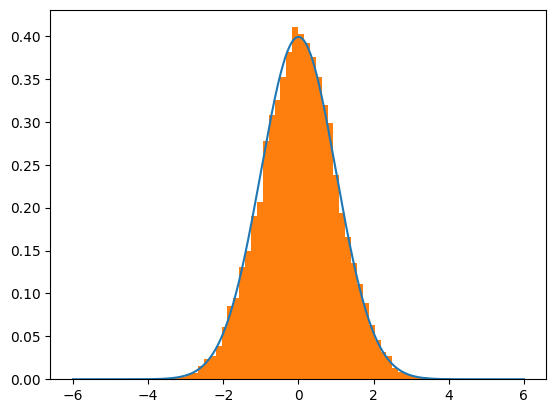

In [4]:
import matplotlib.pyplot as plt
mu = 0
sigma = 1
trial = HMC(mu=mu,sigma=sigma,path_len=1,step_size=0.05, epochs=20000) #note the step_size and path_len parameters

lines = np.linspace(-6,6,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=50)
plt.show()

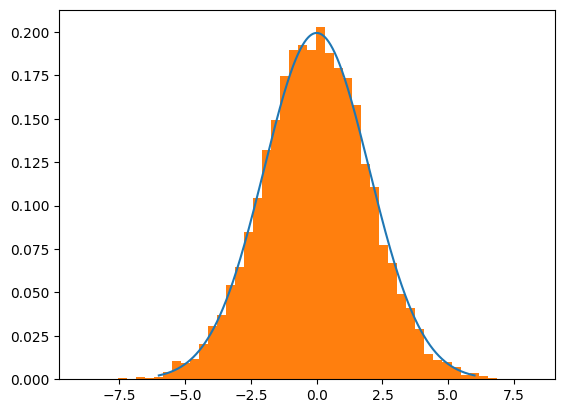

In [5]:
mu = 0
sigma = 2
trial = HMC(mu=mu,sigma=sigma,path_len=1.5,step_size=0.05, epochs=10000) #note the change in step_size and path_len parameters...

lines = np.linspace(-6,6,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=50)
plt.show()

The code above implements a basic form of Hamiltonian Monte Carlo (HMC).
On top of this, No U-Turns (NUTS) offer:

1. **Automatic Termination**: NUTS introduces a criterion for automatically stopping the simulation of the Hamiltonian dynamics, preventing it from making U-turns, which is where its name comes from. This feature helps in dynamically determining the number of steps (steps in your HMC code) without manual tuning.

2. **Adaptive Step Size**: While some HMC implementations might also adapt the step size, NUTS often includes sophisticated mechanisms for adjusting both the number of steps and the step size during the warm-up phase to optimize the exploration of the posterior distribution.

3. **Tree Building Process**: NUTS uses a recursive tree-building process to explore the posterior distribution efficiently. This involves dynamically deciding how far to simulate the trajectory on each iteration, based on the geometry of the target distribution. A binary tree of potential states to explore is part of the mechanism that allows NUTS to decide when to stop extending the trajectory.



---

credits: